AB-MIL vs Rank Induction: p = 0.032, 
CLAM-SB vs Rank Induction: p = 0.081, 
CLAM-MB vs Rank Induction: p = 0.137, 
Attention Induction vs Rank Induction: p = 0.032, 


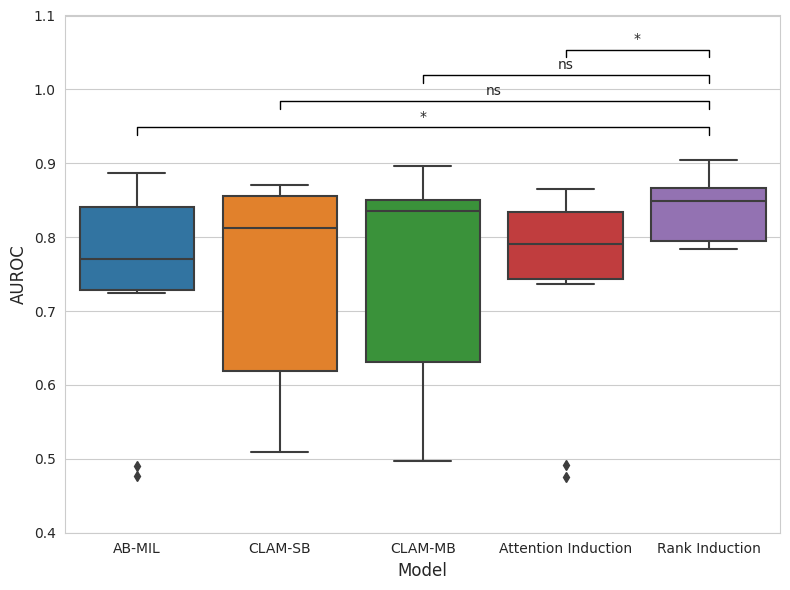

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x='Model', y='auroc', data=df, order=order, showfliers=True)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUROC', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['auroc'].max()
h_step    = 0.035

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    grp_a = df[df['Model']==m]['auroc']
    grp_b = df[df['Model']=='Rank Induction']['auroc']
    _, p  = mannwhitneyu(grp_a, grp_b, alternative='less')
    sig   = sig_label(p)

    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.01
    ax.plot([pos_m, pos_m, pos_rank, pos_rank],
            [y1, y2, y2, y1],
            c='k', linewidth=1.0)

    ax.text((pos_m+pos_rank)/2,
            y2 + 0.005,
            sig,
            ha='center', va='bottom',
            fontsize=10)
    print(f"{m} vs Rank Induction: p = {p:.3f}, ")

ax.set_ylim(0.4, 1.1)

plt.tight_layout()
plt.show()

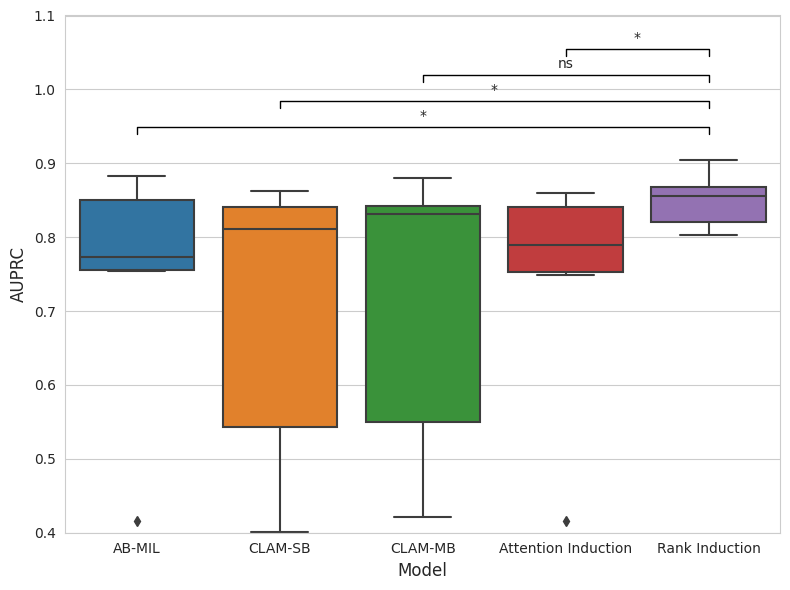

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x='Model', y='auprc', data=df, order=order, showfliers=True)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUPRC', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['auprc'].max()
h_step    = 0.035

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    grp_a = df[df['Model']==m]['auprc']
    grp_b = df[df['Model']=='Rank Induction']['auprc']
    _, p  = mannwhitneyu(grp_a, grp_b, alternative='less')
    sig    = sig_label(p)

    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.01
    ax.plot([pos_m, pos_m, pos_rank, pos_rank],
            [y1, y2, y2, y1],
            c='k', linewidth=1.0)

    ax.text((pos_m+pos_rank)/2,
            y2 + 0.005,
            sig,
            ha='center', va='bottom',
            fontsize=10)

ax.set_ylim(0.4, 1.1)

plt.tight_layout()
plt.show()

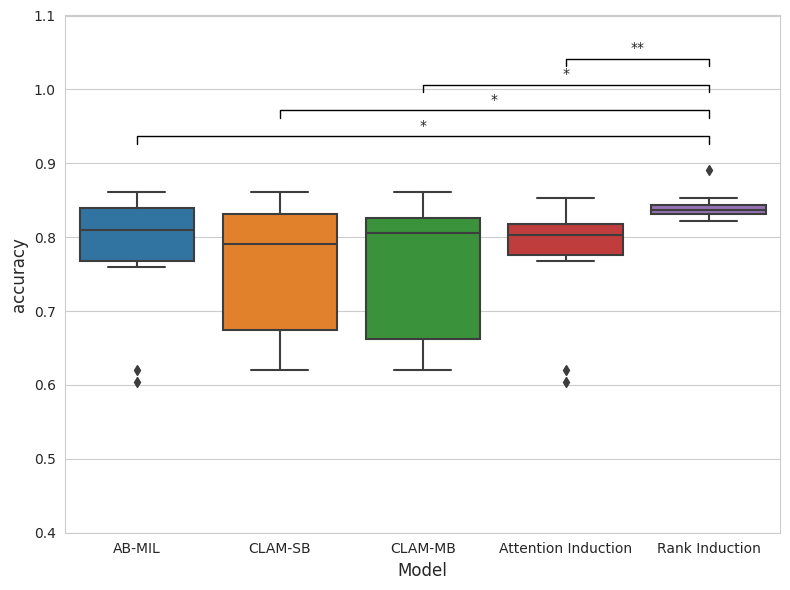

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x='Model', y='accuracy', data=df, order=order, showfliers=True)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['accuracy'].max()
h_step    = 0.035

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    grp_a = df[df['Model']==m]['accuracy']
    grp_b = df[df['Model']=='Rank Induction']['accuracy']
    _, p  = mannwhitneyu(grp_a, grp_b, alternative='less')
    sig    = sig_label(p)

    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.01
    ax.plot([pos_m, pos_m, pos_rank, pos_rank],
            [y1, y2, y2, y1],
            c='k', linewidth=1.0)

    ax.text((pos_m+pos_rank)/2,
            y2 + 0.005,
            sig,
            ha='center', va='bottom',
            fontsize=10)

ax.set_ylim(0.4, 1.1)

plt.tight_layout()
plt.show()

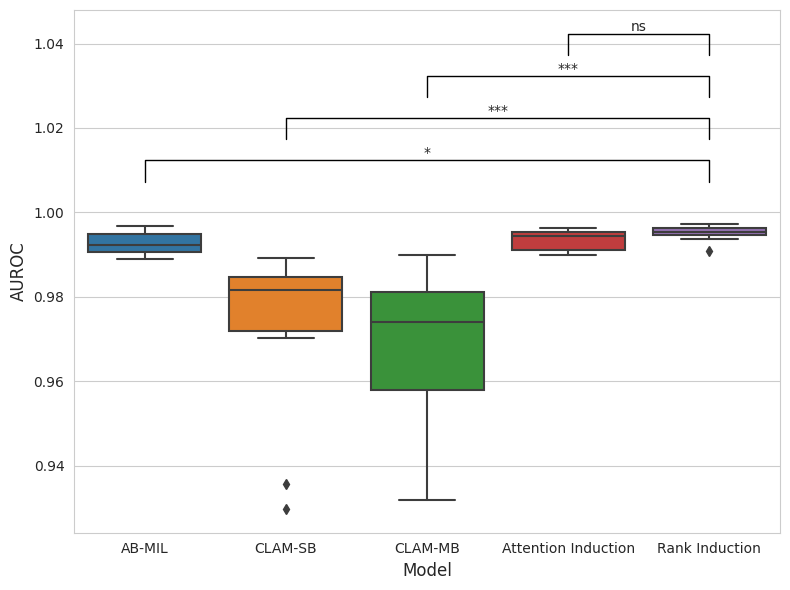

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'digest') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(
    x='Model', 
    y='auroc', 
    data=df, 
    order=order,
    showfliers=True
)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUROC', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['auroc'].max()
h_step    = 0.01  

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    a = df[df['Model']==m]['auroc']
    b = df[df['Model']=='Rank Induction']['auroc']
    _, p = mannwhitneyu(a, b, alternative='less')
    
    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.005
    ax.plot([pos_m, pos_m, pos_rank, pos_rank], [y1, y2, y2, y1], c='k', lw=1.0)
    ax.text((pos_m+pos_rank)/2, y2,
            sig_label(p),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


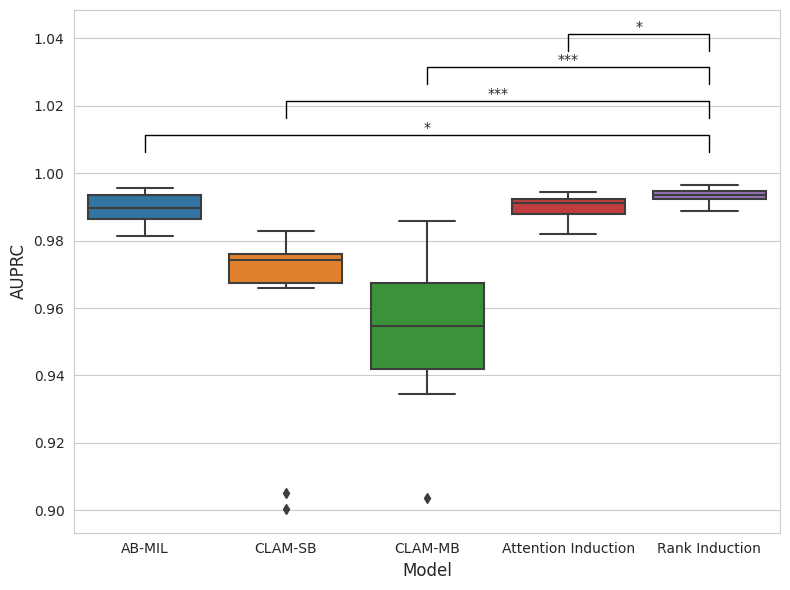

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'digest') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(
    x='Model', 
    y='auprc', 
    data=df, 
    order=order,
    showfliers=True
)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUPRC', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['auprc'].max()
h_step    = 0.01  

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    a = df[df['Model']==m]['auprc']
    b = df[df['Model']=='Rank Induction']['auprc']
    _, p = mannwhitneyu(a, b, alternative='less')
    
    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.005
    ax.plot([pos_m, pos_m, pos_rank, pos_rank], [y1, y2, y2, y1], c='k', lw=1.0)
    ax.text((pos_m+pos_rank)/2, y2,
            sig_label(p),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


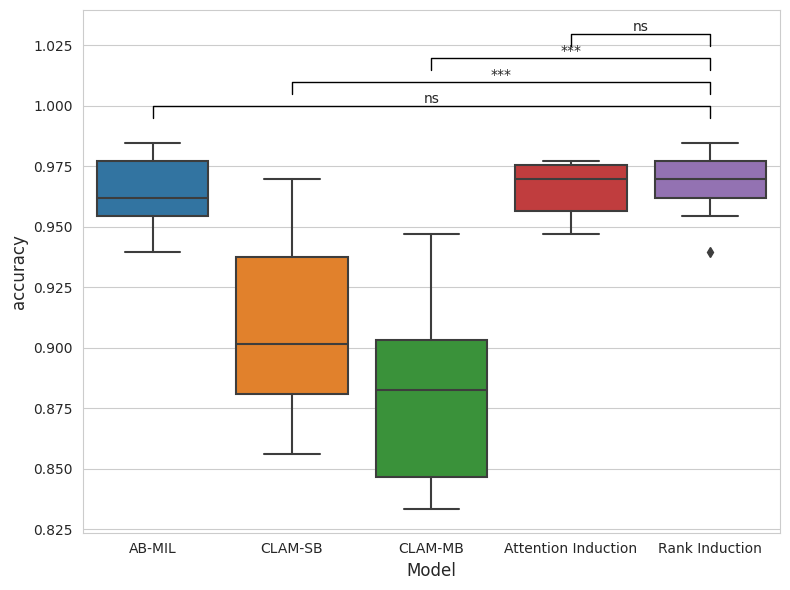

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def sig_label(p):
    if p < 0.001: return '***'
    elif p < 0.01:  return '**'
    elif p < 0.05:  return '*'
    else:           return 'ns'

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'digest') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb', 'clam_mb', 'att', 'abmil', 'rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)
order = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction','Rank Induction']

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
ax = sns.boxplot(
    x='Model', 
    y='accuracy', 
    data=df, 
    order=order,
    showfliers=True
)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)

comparators = ['AB-MIL','CLAM-SB','CLAM-MB','Attention Induction']
pos_rank  = order.index('Rank Induction')
y_max     = df['accuracy'].max()
h_step    = 0.01  

for k, m in enumerate(comparators):
    pos_m = order.index(m)
    a = df[df['Model']==m]['accuracy']
    b = df[df['Model']=='Rank Induction']['accuracy']
    _, p = mannwhitneyu(a, b, alternative='less')
    
    y1 = y_max + h_step*(k+1)
    y2 = y1 + 0.005
    ax.plot([pos_m, pos_m, pos_rank, pos_rank], [y1, y2, y2, y1], c='k', lw=1.0)
    ax.text((pos_m+pos_rank)/2, y2,
            sig_label(p),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb','clam_mb','att','abmil','rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)

metrics = ['auroc','auprc','accuracy']

summary = df.groupby('Model')[metrics].agg(['mean','std']).round(3)

formatted = pd.DataFrame(index=summary.index)

for m in metrics:
    means = summary[(m, 'mean')].map('{:.3f}'.format)
    stds  = summary[(m, 'std')].map('{:.3f}'.format)
    formatted[m] = means + ' ± ' + stds

formatted.index.names = ['Model']

print(formatted)


                             auroc          auprc       accuracy
Model                                                           
AB-MIL               0.741 ± 0.146  0.730 ± 0.183  0.778 ± 0.093
Attention Induction  0.743 ± 0.143  0.728 ± 0.179  0.771 ± 0.086
CLAM-MB              0.754 ± 0.152  0.719 ± 0.195  0.762 ± 0.100
CLAM-SB              0.743 ± 0.146  0.707 ± 0.194  0.762 ± 0.094
Rank Induction       0.840 ± 0.044  0.851 ± 0.037  0.842 ± 0.019


In [ ]:
import pandas as pd

df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'digest') &
    (df['morphology_value'] == 0) &
    (df['anno_ratio'] == 1) &
    (df['model'].isin(['clam_sb','clam_mb','att','abmil','rank'])) &
    (df['sampling_ratio'] == 1) &
    (df['random_state'].between(2018, 2027))
]

name_map = {
    'clam_sb': 'CLAM-SB',
    'clam_mb': 'CLAM-MB',
    'att':     'Attention Induction',
    'abmil':   'AB-MIL',
    'rank':    'Rank Induction'
}
df['Model'] = df['model'].map(name_map)

metrics = ['auroc','auprc','accuracy']

summary = df.groupby('Model')[metrics].agg(['mean','std']).round(3)

formatted = pd.DataFrame(index=summary.index)

for m in metrics:
    means = summary[(m, 'mean')].map('{:.3f}'.format)
    stds  = summary[(m, 'std')].map('{:.3f}'.format)
    formatted[m] = means + ' ± ' + stds

formatted.index.names = ['Model']

print(formatted)

                             auroc          auprc       accuracy
Model                                                           
AB-MIL               0.993 ± 0.003  0.990 ± 0.005  0.964 ± 0.017
Attention Induction  0.994 ± 0.002  0.990 ± 0.004  0.965 ± 0.012
CLAM-MB              0.969 ± 0.018  0.953 ± 0.024  0.882 ± 0.041
CLAM-SB              0.972 ± 0.022  0.961 ± 0.031  0.908 ± 0.040
Rank Induction       0.995 ± 0.002  0.993 ± 0.002  0.967 ± 0.013
